In [ ]:
!mkdir -p ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!echo '{"username":"YOUR-USERNAME","key":"YOUR-API-KEY"}' > ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kartik2112/fraud-detection
!unzip -o fraud-detection.zip

 97% 195M/202M [00:00<00:00, 233MB/s]
100% 202M/202M [00:00<00:00, 224MB/s]
Archive:  fraud-detection.zip
  inflating: fraudTest.csv           
  inflating: fraudTrain.csv          


In [ ]:
!pip install feature-engine

     |████████████████████████████████| 205 kB 12.4 MB/s 
     |████████████████████████████████| 9.8 MB 4.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

master_df = pd.read_csv('fraudTrain.csv', index_col=0)

In [ ]:
# Source: https://stackoverflow.com/a/29546836/6948907

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [ ]:
def is_weekend(txn_time):
    return int(txn_time.weekday() >= 5)

def is_night(txn_time):
    return int(txn_time.hour <= 6 or txn_time.hour >= 22)

In [ ]:
def get_customer_spending_behaviour_features(customer_transactions, windows_size_in_days=[1,7, 15, 30]):

    # Let us first order transactions chronologically
    customer_transactions=customer_transactions.sort_values('trans_date_trans_time')
    
    # The transaction date and time is set as the index, which will allow the use of the rolling function 
    customer_transactions.index=customer_transactions.trans_date_trans_time
    
    # For each window size
    for window_size in windows_size_in_days:
        
        # Compute the sum of the transaction amounts and the number of transactions for the given window size
        SUM_AMOUNT_TX_WINDOW=customer_transactions['amt'].rolling(window_size, min_periods = 1).sum()
        NB_TX_WINDOW=customer_transactions['amt'].rolling(window_size, min_periods = 1).count()

        # Compute the average transaction amount for the given window size
        # NB_TX_WINDOW is always >0 since current transaction is always included
        AVG_AMOUNT_TX_WINDOW=SUM_AMOUNT_TX_WINDOW/NB_TX_WINDOW
        # AVG_AMOUNT_TX_WINDOW.fillna(value=customer_transactions["amt"], inplace = True)

    
        # Save feature values
        customer_transactions['CUSTOMER_ID_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        customer_transactions['CUSTOMER_ID_AVG_AMOUNT_'+str(window_size)+'DAY_WINDOW']=list(AVG_AMOUNT_TX_WINDOW)

    customer_transactions.reset_index(drop = True)
    return customer_transactions

In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from feature_engine.encoding import WoEEncoder, RareLabelEncoder

class Transformer:
    def __init__(self):
        self.rare_encoder = RareLabelEncoder(tol=0.005, n_categories=2, variables=['category', 'job', 'merchant'])
        self.woe_encoder = WoEEncoder(variables=['category', 'job', 'merchant'])
        self.cat_ohe = OneHotEncoder(handle_unknown='ignore')
        self.merchant_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        self.job_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        self.zip_fraud_count = {}
        self.job_fraud_count = {}
        self.sm = SMOTE()
        self.rus = RandomUnderSampler()
        self.scaler = MinMaxScaler()
        self.pca = PCA(n_components=0.5)

    def fit_encoders(self, df, y):
        self.rare_encoder.fit(df)
        # self.woe_encoder.fit(df, y)

        self.cat_ohe.fit(df["category"].values.reshape(-1, 1))
        self.merchant_oe.fit(df["merchant"].values.reshape(-1, 1))
        self.job_oe.fit(df["job"].values.reshape(-1, 1))
        
    def fit_zip_score(self, df, y):
        for idx, zip in df['zip'].iteritems():
            if y[idx] == 1:
                if zip in self.zip_fraud_count:
                    self.zip_fraud_count[zip] += 1
                else:
                    self.zip_fraud_count[zip] = 1
            else:
                if not zip in self.zip_fraud_count:
                    self.zip_fraud_count[zip] = 0

    def fit_job_score(self, df, y):
        for idx, job in df['job'].iteritems():
            if y[idx] == 1:
                if job in self.job_fraud_count:
                    self.job_fraud_count[job] += 1
                else:
                    self.job_fraud_count[job] = 1
            else:
                if not job in self.job_fraud_count:
                    self.job_fraud_count[job] = 0

    def fit(self, df, y):
        self.fit_encoders(df, y)
        self.fit_zip_score(df, y)
        self.fit_job_score(df, y)

    def encode_categorical(self, df):
        # df = self.rare_encoder.transform(df)
        # return self.woe_encoder.transform(df)

        return self.rare_encoder.transform(df)

    def transform(self, df, y):
        df = df.groupby('cc_num').apply(lambda x: get_customer_spending_behaviour_features(x, windows_size_in_days=[1,7,15,30,60]))
        df.reset_index(drop=True, inplace = True)
        df = df.sort_values('trans_date_trans_time')

        df['gender'] = df['gender'].transform(lambda g: 1 if g == 'F' else 0)
        df['distance_bet_user_merchant'] = haversine_np(df['lat'],df['long'],df['merch_lat'],df['merch_long'])
        df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
        df['dob'] = pd.to_datetime(df['dob'])
        df['user_age'] = (df['trans_date_trans_time'] - df['dob']).astype('<m8[Y]').apply(pd.to_numeric)
        df['txn_at_night'] = df['trans_date_trans_time'].apply(lambda txn_time: is_night(txn_time))
        df['txn_on_weekend'] = df['trans_date_trans_time'].apply(lambda txn_time: is_weekend(txn_time))

        df['zip_score']= df['zip'].apply(lambda zip: self.zip_fraud_count.get(zip, 0))
        df['job_score']= df['job'].apply(lambda job: self.job_fraud_count.get(job, 0))

        df.drop(axis=1, inplace=True, columns=[
                'trans_num', 'street', 'first', 'last', 'unix_time', 'city', 'state',
                'trans_date_trans_time', 'dob', 'job', 'is_fraud', 'category', 'merchant',
                'zip', 'lat', 'long', 'merch_lat', 'merch_long',
            ]
        )   

        return df

    def scale(self, df, fit: bool = False):
        if fit:
            self.scaler.fit(df)

        return self.scaler.transform(df)        

    def run_pca(self, df, fit: bool = False):
        if fit:
            self.pca.fit(df)

        df = self.pca.transform(df)
        return df

    def oversample(self, x, y):
        return self.sm.fit_resample(x, y.ravel())

    def undersample(self, x, y):
        return self.rus.fit_resample(x, y.ravel())

In [ ]:
train_x = master_df
train_x.reset_index(drop=True, inplace=True)
train_y = train_x['is_fraud']

In [ ]:
transformer = Transformer()
transformer.fit(train_x, train_y)
train_x = transformer.encode_categorical(train_x)
train_x = transformer.transform(train_x, train_y)

In [ ]:
train_x.columns

Index(['cc_num', 'amt', 'gender', 'city_pop', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_15DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_15DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'CUSTOMER_ID_NB_TX_60DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_60DAY_WINDOW', 'distance_bet_user_merchant',
       'user_age', 'txn_at_night', 'txn_on_weekend', 'zip_score', 'job_score'],
      dtype='object')

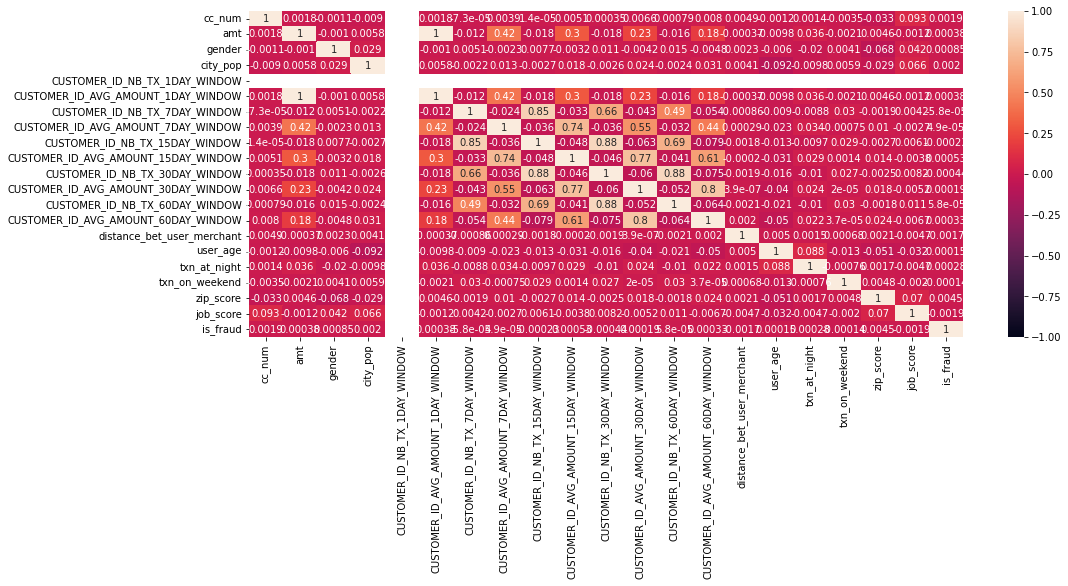

In [ ]:
temp_df = train_x
temp_df['is_fraud'] = train_y
plt.figure(figsize=(16, 6))
sns.heatmap(temp_df.corr(), vmin=-1, vmax=1, annot=True)

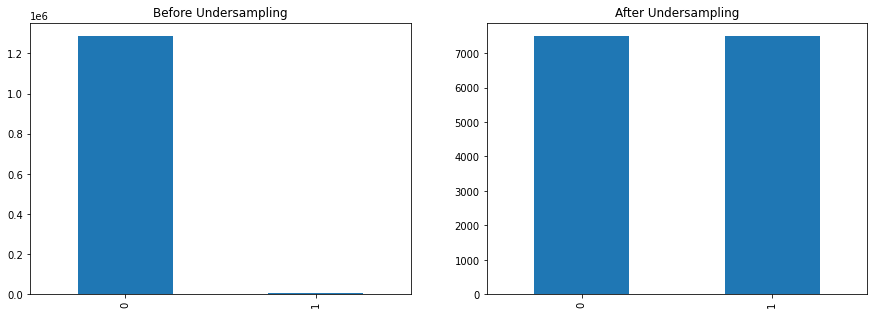

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(15, 5))
ax1.set_title('Before Undersampling')
pd.Series(train_y).value_counts().plot.bar(ax=ax1)

train_x, train_y = transformer.undersample(train_x, train_y)

ax2.set_title('After Undersampling')  
pd.Series(train_y).value_counts().plot.bar(ax=ax2)

plt.show()

In [ ]:
# train_x = transformer.scale(train_x, fit=True).run_pca(train_x, fit=True)

In [ ]:
from sklearn.linear_model import LogisticRegression

MAX_ITER = 500
classifier = LogisticRegression()
classifier.fit(train_x, train_y)

LogisticRegression()

In [ ]:
from sklearn.metrics import confusion_matrix

print(classifier.score(train_x, train_y))
print(confusion_matrix(train_y, classifier.predict(train_x)))

0.5
[[   0 7506]
 [   0 7506]]


In [ ]:
test_df = pd.read_csv('fraudTest.csv', index_col=0)
test_y = test_df['is_fraud']
test_df.drop(columns=['is_fraud'], axis=1, inplace=True)

In [ ]:
test_df = transformer.encode_categorical(test_df)
test_df = transformer.transform(test_df, test_y)
test_df = transformer.run_pca(test_df)

print(classifier.score(test_df, test_y))
confusion_matrix(test_y, classifier.predict(test_df))

ValueError: ignored

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(classifier.predict(test_df), test_y))

In [ ]:
train_x['y'] = train_y
train_x.corr()['y'].abs().sort_values(ascending=False)